# Investigating the Dynamics of Water with Classical Molecular Dynamics Simulations

## Part 0 - Setting up the environment for Molecular Dynamics Simulations. 

First, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

Anaconda (https://docs.conda.io/en/latest/miniconda.html)  
OpenMM (https://openmm.org/)  
MDAnalysis (https://www.mdanalysis.org/)  
Numpy (https://numpy.org/)  
Pandas (https://pandas.pydata.org/)  
Matplotlib (https://matplotlib.org/)

#### Only Execute the Next Two Cells if Using Google Colab

In [ ]:
#@title ### **Import Google Drive**
#@markdown Click the "Run" buttom to make your Google Drive accessible. Only run this command if in Google Colab!
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

In [ ]:
#@title **Check if you correctly allocated GPU nodes**
#@markdown Again, only run this command if you are running this code in Google Colab!

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [ ]:
#@title **Install dependencies**
#@markdown It will take a few minutes, please, drink a coffee and wait.
# install dependencies
#%%capture
!pip -q install py3Dmol
!pip install git+https://github.com/pablo-arantes/biopandas
!conda install mamba -c conda-forge -y
!mamba install -c conda-forge gcc=12.1.0 -y
!mamba install openmm -c conda-forge -y
!pip install --upgrade MDAnalysis
!pip install seaborn

In [4]:
#@title **Load dependencies**
import sys
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import os
import urllib.request  
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis.dielectric import DielectricConstant
from MDAnalysis.analysis.rdf import InterRDF
import py3Dmol
import platform
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from matplotlib import colors
from IPython.display import set_matplotlib_formats

#conversion factors to get to correct units
mass_to_kg = 1.66054e-27
angstrom_to_m = 1e-10
ps_to_s = 1e-12
avogadro = 6.022e23

#file locations
tip3p_traj = "tip3p-traj.dcd"
tip3p_log = "tip3p_log.csv"
tip3p_pdb = "tip3p_minimized.pdb"

tip4p_traj = "tip4p-traj.dcd"
tip4p_log = "tip4p-log.csv"
tip4p_pdb = "tip4p_minimized.pdb"

## Part 1 - Preparing & Running a Molecular Dynamics Simulation of Water

In [ ]:
#@title **Cosntruct the System**
#@markdown Create a box with randomly placed TIP3P water molecules with periodic boundary conditions

forcefield = ForceField("amber14-all.xml", "amber14/tip3p.xml")
modeller = Modeller(Topology(), [])
modeller.addSolvent(forcefield, boxSize=Vec3(3, 3, 3)*nanometers, model='tip3p', neutralize=True, negativeIon='Cl-', positiveIon='Na+')
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds)
print("Number of TIP3P water molecules in box in (3 nm)^3 cubic box: ", len(modeller.getPositions())/3) #divide by number of atoms in molecule (3)

In [44]:
#@title **Add termostat & barostat. Run energy minimization.**
#@markdown Here we define the temperature of the system (300 K), the pressure (1 bar), assign random velocities to particles/molecules, and define our time step (dt) to be 2 fs. Then, we run a gradient descent energy minimization on the system.

system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds)
system.addForce(MonteCarloBarostat(1*bar, 300*kelvin))
integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)
simulation.minimizeEnergy(tolerance=0.1*kilojoule/mole, maxIterations=100000)

positions = simulation.context.getState(getPositions=True).getPositions()
PDBFile.writeFile(simulation.topology, positions, open(tip3p_pdb, 'w'))


In [ ]:
#@title **Visualize the System**

view = py3Dmol.view(width=500, height=500)
view.addModel(open( 'minimized.pdb' ,'r').read(),'pdb')
view.setStyle({'stick':{}} )
view.addSurface(py3Dmol.SAS, {'opacity': 0.3, 'color':'blue'})
view.zoomTo()
view.show()

In [ ]:
#@title Run a Production Molecular Dynamics Simulation
#@markdown This simulation should produce a ~45 MB trajectory file called traj.dcd in your Google Drive. The trajectory will contain dynamics information of water molecules over the course of 30 ns.

simulation.reporters = []
#record positions every 100 steps
simulation.reporters.append(DCDReporter(tip3p_traj, 100))
simulation.reporters.append(StateDataReporter(tip3p_log, 500, step=True, time=True,
                                              temperature=True, kineticEnergy=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter(sys.stdout, 1000, step=True, time=True, elapsedTime=True))

#run the simulation for defined number of steps with timestep of 2 fs
simulation.step(15000)

## Part 2 - Analyzing the Simulation

In [ ]:
#@title Plotting Instantaneous Temperature and the Running Average Temperature
#@markdown 

tip3p_data = pd.read_csv(tip3p_log)

#calculate rolling average of the temperature
rolling_avg = []
for i in range(len(tip3p_data["Temperature (K)"])):
    j = i
    rolling_avg.append(0)
    while j >= 0 and j >= i-4:
        rolling_avg[i] += tip3p_data["Temperature (K)"][j]
        j -= 1
    if i < 4:
        rolling_avg[i] = rolling_avg[i]/(i+1)
    else:
        rolling_avg[i] = rolling_avg[i]/(5)

tip3p_data['Rolling Avg Temperature (K)'] = rolling_avg
tip3p_data.plot(x="Time (ps)", y=["Temperature (K)", "Rolling Avg Temperature (K)"], style='-')

In [ ]:
#@title System Temperature and the Equipartition Theorem
#@markdown 

print("Average Temperature (K): ", tip3p_data["Temperature (K)"].mean())
print("Average Kinetic Energy (kJ/mole): ", tip3p_data["Kinetic Energy (kJ/mole)"].mean())
print("(<KE>/<T>)*(1/Avogadro's Number): ", (tip3p_data["Kinetic Energy (kJ/mole)"].mean()/tip3p_data["Temperature (K)"].mean())/avogadro)

Result of integrating over g(r) through the first peak (0 to 3.3 A):  1.042074808133393


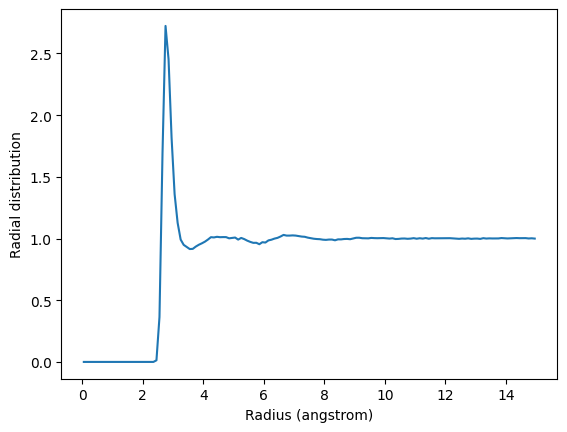

In [18]:
#@title Radial Distribution Function
#@markdown 

universe = mda.Universe(tip3p_pdb, tip3p_traj)
water = universe.select_atoms("resname HOH")

rdf = InterRDF(oxygen, oxygen, nbins=150, exclusion_block=(3, 3))
rdf.run()

plt.plot(rdf.bins, rdf.rdf)
plt.xlabel('Radius [angstrom]')
plt.ylabel('Radial distribution (g(r))')

#bins start at 0.1 and increment by 0.1. Want to integrate out to 3.3 A
sum = 0
integration_range = int((3.3-0.1)/0.1)
for i in range(integration_range):
    sum += rdf.rdf[i]*0.1

print("Result of integrating over g(r) through the first peak (0 to 3.3 A): ", sum)

In [ ]:
#@title Calculate the density and dielectric constant of TIP3P water
#@markdown 

universe = mda.Universe(tip3p_pdb, tip3p_traj)
water = universe.select_atoms("resname HOH")

#mass density of water - first calculate total mass of water in box
water_mass = 0
for i in range(len(water)):
    water_mass += water[i].mass * mass_to_kg

av_density = 0
for p in range(25, len(universe.trajectory)):
    universe.trajectory[p]

    volume = (universe.trajectory[p].dimensions[0]*angstrom_to_m) * (universe.trajectory[p].dimensions[1]*angstrom_to_m) * (universe.trajectory[p].dimensions[2]*angstrom_to_m)
    av_density += water_mass/volume

av_density = av_density/len(universe.trajectory)
print("The average density of TIP3P water is: ", av_density, " [kg/m^3]")


#dielectric constant of water

#need charges from OpenMM
n_atoms = system.getNumParticles()
charges = []
nonbonded = [f for f in system.getForces() if isinstance(f, NonbondedForce)][0]
for i in range(n_atoms):
    charge, sigma, epsilon = nonbonded.getParticleParameters(i)
    charges.append(charge._value)

#add this to universe topology
universe.add_TopologyAttr('charges', charges)

#need to add bond information as well
bonds = []
for o in range(0, n_atoms, 3):
    bonds.extend([(o, o+1), (o, o+2)])

universe.add_TopologyAttr('bonds', bonds)

#Finally calculate the dielectric constant
diel = DielectricConstant(universe.atoms)
diel.run()
print("Dielectric constant of TIP3P water: ", diel.results.eps_mean)

### A Different Representation of Water: TIP4P/2005

In [ ]:
#@title Simulate TIP4P/2005 water model

#system setup
forcefield = ForceField("charmm36.xml", "charmm36/tip4p2005.xml")
modeller = Modeller(Topology(), [])
modeller.addSolvent(forcefield, boxSize=Vec3(3, 3, 3)*nanometers, model='tip4pew', neutralize=True, negativeIon='Cl-', positiveIon='Na+')
modeller.addExtraParticles(forcefield)
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds)
print("Number of TIP4P/2005 water molecules in box in (3 nm)^3 cubic box: ", len(modeller.getPositions())/4) #divide by number of atoms in molecule (4)

#simulation details and energy minimization
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME,
        nonbondedCutoff=1*nanometer, constraints=HBonds)
system.addForce(MonteCarloBarostat(1*bar, 300*kelvin))
integrator = LangevinIntegrator(300*kelvin, 1/picosecond, 0.002*picoseconds)
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)
simulation.minimizeEnergy(tolerance=0.1*kilojoule/mole, maxIterations=100000)

positions = simulation.context.getState(getPositions=True).getPositions()
PDBFile.writeFile(simulation.topology, positions, open(tip4p_pdb, 'w'))

#running simulation
simulation.reporters = []
simulation.reporters.append(DCDReporter(tip4p_traj, 100))
simulation.reporters.append(StateDataReporter(tip4p_log, 500, step=True, time=True,
                                              temperature=True, kineticEnergy=True, elapsedTime=True))
simulation.reporters.append(StateDataReporter(sys.stdout, 1000, step=True, time=True, elapsedTime=True))

simulation.step(15000)

In [ ]:
#@title Calculate the density and dielectric constant of TIP4P/2005 to compare with TIP3P

#begin analysis
universe = mda.Universe(tip4p_pdb, tip4p_traj)
water = universe.select_atoms("resname HOH")

#mass density of water - first calculate total mass of water in box
water_mass = 0
for i in range(len(water)):
    water_mass += water[i].mass * mass_to_kg

av_density = 0
for p in range(0, len(universe.trajectory)):
    universe.trajectory[p]

    volume = (universe.trajectory[p].dimensions[0]*angstrom_to_m) * (universe.trajectory[p].dimensions[1]*angstrom_to_m) * (universe.trajectory[p].dimensions[2]*angstrom_to_m)
    av_density += water_mass/volume

av_density = av_density/len(universe.trajectory)
print("The average density of TIP4P/2005 water is: ", av_density, " [kg/m^3]")


#dielectric constant of water

#need charges from OpenMM
n_atoms = system.getNumParticles()
charges = []
nonbonded = [f for f in system.getForces() if isinstance(f, NonbondedForce)][0]
for i in range(n_atoms):
    charge, sigma, epsilon = nonbonded.getParticleParameters(i)
    charges.append(charge._value)

#need to swap index i and i+3 because list 'charges' above because the oxygen and virtual site are swapped
for i in range(0, n_atoms, 4):
    tmp = charges[i]
    charges[i] = charges[i+3]
    charges[i+3] = tmp

#add this to universe topology
universe.add_TopologyAttr('charges', charges)

#need to add bond information as well
bonds = []
for o in range(0, n_atoms, 4):
    bonds.extend([(o, o+1), (o, o+2), (o, o+3)]) #extra term for the virtual particle

universe.add_TopologyAttr('bonds', bonds)

#Finally calculate the dielectric constant
diel = DielectricConstant(universe.atoms)
diel.run()
print("Dielectric constant of TIP4P/2005 water: ", diel.results.eps_mean)

## Part 3 - Modeling the Freezing of Water with TIP4P/2005